# Poisonous mushrooms

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

import pandas as pd
from itertools import product
import random

# Set random seed
random.seed(0)

print 'Finished'

Finished


## Loading the data

In [3]:
X, Y = [], []

with open('datasets/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

print 'Done'

Done


### Doing PCA and showing the total variance of the k component

In [4]:
pca = PCA(random_state = 0)
pca.fit(train_data)

# Getting the variance into dataframe
var_pd = pd.DataFrame.from_dict({
    
    'Variance': pca.explained_variance_,
    'Variance Fraction': pca.explained_variance_ratio_
                                
})

# Adding cumulative columns
var_pd['Variance Cumulative Sum'] = var_pd['Variance'].cumsum()
var_pd['Variance Fraction Cumulative Sum'] = var_pd['Variance Fraction'].cumsum()

# Clarifying the index
var_pd.index += 1 
var_pd.index.name = 'Component'

# Produce result
print "The explained variance for the first 50 components is:"
var_pd.head(50)

The explained variance for the first 50 components is:


,Variance,Variance Fraction,Variance Cumulative Sum,Variance Fraction Cumulative Sum
Component,,,,
1,1.865073,0.164043,1.865073,0.164043
2,1.514799,0.133235,3.379872,0.297278
3,1.156661,0.101735,4.536533,0.399013
4,0.803061,0.070634,5.339594,0.469646
5,0.439614,0.038666,5.779208,0.508313
6,0.418485,0.036808,6.197693,0.545121
7,0.355662,0.031282,6.553355,0.576403
8,0.310809,0.027337,6.864165,0.603741
9,0.297479,0.026165,7.161644,0.629905


## Visualizing the top 2 PCA'ed components

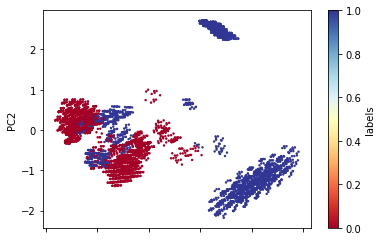

In [5]:
def clean_data(components, df_data, labels):
    df_data['labels'] = labels
    
    name_map = {}
    
    for i in range(0,components):
        name_map[i] = 'PC' + str(i+1)
    
    df_data = df_data.rename(name_map, axis=1)
    
    return df_data
    

def make_pca(components, train_data, test_data, train_labels, test_labels):
    pca = PCA(n_components = components)
    
    train_data_pca = pca.fit_transform(train_data)
    test_data_pca = pca.transform(test_data)
    
    df_train_data_temp = pd.DataFrame(train_data_pca)
    df_test_data_temp = pd.DataFrame(test_data_pca)
    
    df_train_data_final = clean_data(components, df_train_data_temp, train_labels)
    df_test_data_final = clean_data(components, df_test_data_temp, test_labels)
    
    return df_train_data_final, df_test_data_final


# Convert the data

df_train_data, df_test_data = make_pca(2, train_data, test_data, train_labels, test_labels)

# Plot df_train_data. Red = negative / Blue = positive
simple_plot = df_train_data.plot.scatter(x='PC1',y='PC2',c='labels',colormap='RdYlBu', s=2)

## Optimizing for number of Kmean centroids

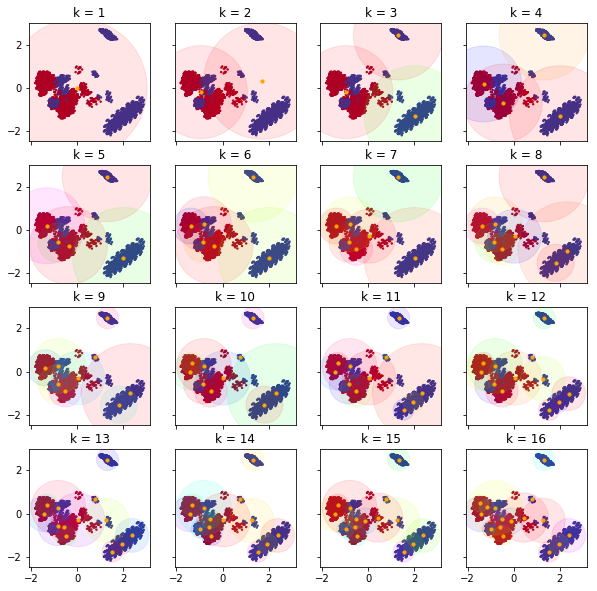

In [6]:
def plot_kmeans():
    
    # Defining plot area and initial parameters
    f, axarr = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
    x,y = 0,0

    for i in range(1,17):
        # Training the K-means
        n_clusters = i
        cls = KMeans(n_clusters = n_clusters)
        cls.fit(df_train_data)

        # Matching centroid to their coordinates
        centroids_coordinates = cls.cluster_centers_

        centroid_x = {}
        centroid_y = {}
        for index,coordinate in enumerate(centroids_coordinates):
            centroid_x[index] = centroids_coordinates[index][0]
            centroid_y[index] = centroids_coordinates[index][1]

        # Getting point/distance that's farthest away for each centroid
        df_centroid = pd.DataFrame()
        df_centroid = df_train_data
        df_centroid['centroid'] = cls.labels_
        df_centroid['centroid_x'] = df_centroid['centroid'].map(centroid_x)
        df_centroid['centroid_y'] = df_centroid['centroid'].map(centroid_y)
        df_centroid['distance'] = ((df_centroid['centroid_x'] - df_centroid['PC1'])**2 + (df_centroid['centroid_y'] - df_centroid['PC2'])**2).apply(np.sqrt)

        max_dist_map = df_centroid.groupby(['centroid','centroid_x','centroid_y'], sort=False)['distance'].max()
        max_dist_map = max_dist_map.to_frame().reset_index()

        # Plot the data :
        main = axarr[x, y].scatter(df_centroid['PC1'], df_centroid['PC2'], c=df_centroid['labels'], cmap='RdYlBu', s=2)
        centroids = axarr[x, y].scatter(max_dist_map['centroid_x'], max_dist_map['centroid_y'], c=np.random.rand(n_clusters,), alpha=0.1, cmap='hsv')
        centroid_points = axarr[x, y].scatter(max_dist_map['centroid_x'], max_dist_map['centroid_y'], c='orange', s=10)
        
        # Calculate radius in pixels:
        r = max_dist_map['distance']
        N = len(max_dist_map.index)

        rr_pix = (axarr[x, y].transData.transform(np.vstack([r, r]).T) - axarr[x, y].transData.transform(np.vstack([np.zeros(N), np.zeros(N)]).T))
        rpix, _ = rr_pix.T

        # Calculate and update size in points:
        size_pt = (2*rpix/f.dpi*72)**2
        centroids.set_sizes(size_pt)
        
        axarr[x, y].set_title('k = {k}'.format(k=i))
        
        if y == 3:
            y = 0
            x += 1
        else:
            y +=1

df_train_data, df_test_data = make_pca(2, train_data, test_data, train_labels, test_labels)

# Orange represents the different centroids and then the areas they cover are shown by the different colors. 
plot_kmeans()

## Optimizing GMM parameters

C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


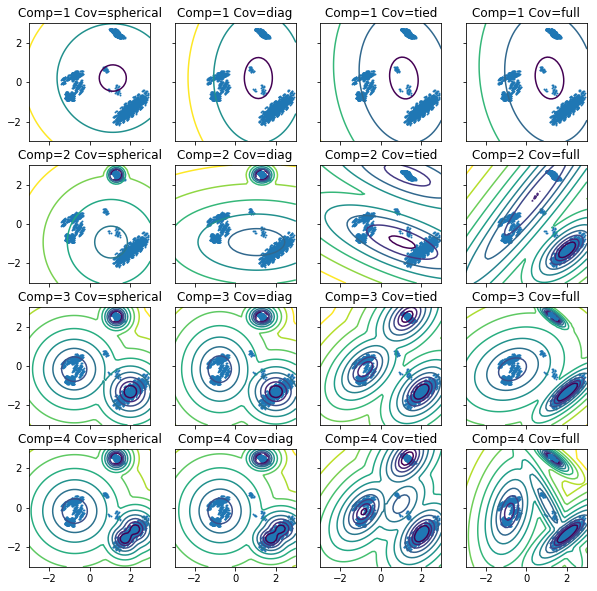

In [7]:

def make_mixture_model(data):
    
    # Defining initial parameters
    
    a = [1, 2, 3, 4]
    b = ['spherical', 'diag', 'tied', 'full']
    
    f, axarr = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
    s,t = 0,0

    for component, matrix in list(product(a, b)):
        
        # Training the model 
        clf = GaussianMixture(n_components=component, covariance_type=matrix)
        clf.fit(data)

        # display predicted scores by the model as a contour plot
        x,y  = np.linspace(-3,3), np.linspace(-3,3)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -clf.score_samples(XX)
        Z = Z.reshape(X.shape)

        CS = axarr[s,t].contour(X, Y, Z, norm=LogNorm(), levels=np.logspace(0, 3, 15))
        
        axarr[s,t].scatter(data.iloc[:, 0], data.iloc[:, 1], .8)

        axarr[s,t].set_title('Comp={k} Cov={cov}'.format(k=component, cov=matrix))
        
        if t == 3:
            t = 0
            s += 1
        else:
            t +=1
        
df_train_data, df_test_data = make_pca(2, train_data, test_data, train_labels, test_labels)
df_positive = df_train_data[['PC1','PC2']][df_train_data['labels'] == 1]

make_mixture_model(df_positive) 

## Testing two 4-component full covariance GMMs
### One on positive samples, another on negative samples

In [8]:
def getGmmProb(train_data, test_data, component, matrix):
    
    clf = GaussianMixture(
        n_components=component, 
        covariance_type=matrix, 
        random_state=0, 
        max_iter=500, 
        n_init=10, 
        tol=0.0000001
    )
    
    pclist = []
    
    for i in range(1,train_data.shape[1]):
        pclist.append('PC'+str(i))
    
    clf.fit(train_data[pclist])
    
    # score_samples seems to be the equivalent of the depricated GMM.score
    
    return clf.score_samples(test_data[pclist])
    

def gmm_outacc(train_data, test_data, component, matrix):
    
    df_positive_train = train_data[train_data['labels'] == 1]
    df_negative_train = train_data[train_data['labels'] == 0]
    
    pos = getGmmProb(df_positive_train, test_data, component, matrix)
    neg = getGmmProb(df_negative_train, test_data, component, matrix)
    
    predict =[]
    
    for p, n in zip(pos, neg):
        if p > n:
            predict.append(1)
        else:
            predict.append(0)
            
    return metrics.accuracy_score(test_data['labels'], predict)


df_train_data, df_test_data = make_pca(2, train_data, test_data, train_labels, test_labels)
print 'The accuracy is', gmm_outacc(df_train_data, df_test_data, 4, 'full')


The accuracy is 0.951067615658363


## Optimize GMM more. Going to keep number of parameters to below 50

In [9]:

# Defining function to run each experiment. Both of the inner functions are defined above.

def run_experiment(pca, com, matrix, params):
    
    df_train_data_q6, df_test_data_q6 = make_pca(pca, train_data, test_data, train_labels, test_labels)    
    model_accuracy= gmm_outacc(df_train_data_q6, df_test_data_q6, com, matrix)
     
    return pca, com, matrix, params, model_accuracy

# Defining initial variables, pca components to try, gmm components to try, covariance type and the total parameter formulas. 

pca_num = [1, 3, 5, 7, 9]
gmm_com = [1, 3, 5, 7, 9]
gmm_matrix = ['spherical', 'diag', 'tied', 'full']

gmm_formulas = {
    'spherical': '(1+{pca})*{gmm}*2',
    'diag':'{pca}*2*{gmm}*2',
    'tied':'({pca}**2 + {pca}*{gmm})*2',
    'full':'({pca}**2 + {pca})*{gmm}*2'
}

results = []

# Perform the experimentation

for pca, com, matrix in list(product(pca_num, gmm_com, gmm_matrix)):
    formula = gmm_formulas[matrix]
    formula = 'params = ' + formula.format(pca=pca, gmm=com)
    
    exec(formula)
    
    if params > 50:
        continue
    else:
        results.append(run_experiment(pca, com, matrix, params))
        
# Output result

summary_df = pd.DataFrame([{i: v for i,v in enumerate(row)} for row in results])
summary_df.columns = ['PCA Number', 'GMM Components', 'GMM Matrix', 'Total Parameters', 'Accuracy']
summary_df = summary_df.sort_values(by=['Accuracy'], ascending=False)  

summary_df

# To accomodate for long training time,
# (7, 3, 'spherical', 48, 0.9733096085409253) seems to be the best result. 

C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


,PCA Number,GMM Components,GMM Matrix,Total Parameters,Accuracy
34,7,3,spherical,48,0.973310
31,5,3,spherical,36,0.966192
27,3,5,spherical,40,0.956406
28,3,5,tied,48,0.952847
26,3,3,tied,36,0.923488
12,1,7,spherical,28,0.915480
13,1,7,diag,28,0.915480
6,1,3,tied,8,0.915480
8,1,5,spherical,20,0.915480
9,1,5,diag,20,0.915480
